In [4]:
import torch
import torch.nn as nn
import torch_geometric
from src.layer.wavelet_weights import WaveletCoefs
from src.layer.encoders import TrigonometricEncoder

<Axes: >

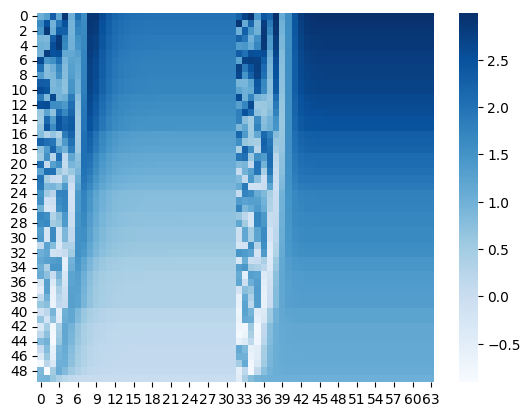

In [6]:
import numpy as np 
import seaborn as sns

eigvs = torch.tensor(np.random.uniform(0,2, (64,50) ),
                      dtype=torch.float32).sort(
    axis=1,descending=True).values
d = 64

pe = TrigonometricEncoder(d, 100, project=False)
pos = pe(eigvs)
sns.heatmap(pos.detach()[0], cmap='Blues')

In [8]:
coefs_function = WaveletCoefs(d, 0.01, 4)

In [9]:
coefs = coefs_function(eigvs)

In [10]:
coefs.shape

torch.Size([64, 50, 64])